# 6.Prophet

In [8]:
# INSTALAR ANTES
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 134 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6639122 sha256=8a9a35e2f2685ba0734ae9088233b72abcad895785d518b3aa79b857bf939b08
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the 

In [9]:
# Bibliotecas básicas 
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns

# Definições estéticas
plt.style.use('ggplot')
color_pal = sns.color_palette()
sns.set(rc={'figure.figsize':(20,10)})

In [31]:
# Base de dados
treino = pd.read_csv('/content/treino.csv')
treino = treino.set_index('Datetime')
treino.index = pd.to_datetime(treino.index)

teste = pd.read_csv('/content/teste.csv')
teste = teste.set_index('Datetime')
teste.index = pd.to_datetime(teste.index)

In [32]:
# Importando bibliotecas
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [33]:
# Função para criar características do datetime e separar X e y
# X são as variáveis e y é o dado de interesse
def create_xy(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [34]:
X_treino, y_treino = create_xy(treino, label='PJME_MW')
X_teste, y_teste = create_xy(teste, label='PJME_MW')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


In [35]:
# Precisei imporatar a base de dados novamente
# A célular anterior modificava 'treino' e 'teste' além de criar as  X e y
treino = pd.read_csv('/content/treino.csv')
treino = treino.set_index('Datetime')
treino.index = pd.to_datetime(treino.index)

teste = pd.read_csv('/content/teste.csv')
teste = teste.set_index('Datetime')
teste.index = pd.to_datetime(teste.index)

In [36]:
treino.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [37]:
# Formatar base de dados para o formato do Prophet, usando 'ds' e 'y'
treino.reset_index() \
      .rename(columns={'Datetime':'ds',
                      'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [38]:
# Preparar e treinar o modelo
model = Prophet()
model.fit(treino.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

In [40]:
# Previsao com o modelo treinado
# Predict on training set with model
previsao_prophet = model.predict(df=teste.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [41]:
# O Prophet devolve muitos itens
# A previsao é o 'yhat'
previsao_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31203.026169,25518.177102,34666.898730,31203.026169,31203.026169,-814.311297,-814.311297,-814.311297,-2412.321635,...,1288.719052,1288.719052,1288.719052,309.291286,309.291286,309.291286,0.0,0.0,0.0,30388.714872
1,2015-01-01 01:00:00,31202.987858,23836.271860,32870.058419,31202.987858,31202.987858,-2838.630791,-2838.630791,-2838.630791,-4430.468275,...,1281.275847,1281.275847,1281.275847,310.561637,310.561637,310.561637,0.0,0.0,0.0,28364.357067
2,2015-01-01 02:00:00,31202.949546,22348.660108,31284.880066,31202.949546,31202.949546,-4342.880735,-4342.880735,-4342.880735,-5927.273753,...,1272.519555,1272.519555,1272.519555,311.873462,311.873462,311.873462,0.0,0.0,0.0,26860.068811
3,2015-01-01 03:00:00,31202.911235,21228.296780,30335.511713,31202.911235,31202.911235,-5214.491338,-5214.491338,-5214.491338,-6790.276523,...,1262.558395,1262.558395,1262.558395,313.226790,313.226790,313.226790,0.0,0.0,0.0,25988.419897
4,2015-01-01 04:00:00,31202.872924,21579.657847,30406.788322,31202.872924,31202.872924,-5356.035008,-5356.035008,-5356.035008,-6922.172576,...,1251.515922,1251.515922,1251.515922,314.621646,314.621646,314.621646,0.0,0.0,0.0,25846.837916


In [39]:
# Plotar os componentes do modelo
# fig = model.plot_components(pjme_test_fcst)

In [45]:
previsao_prophet = pd.Series(previsao_prophet.yhat.to_numpy(), index = teste.index)

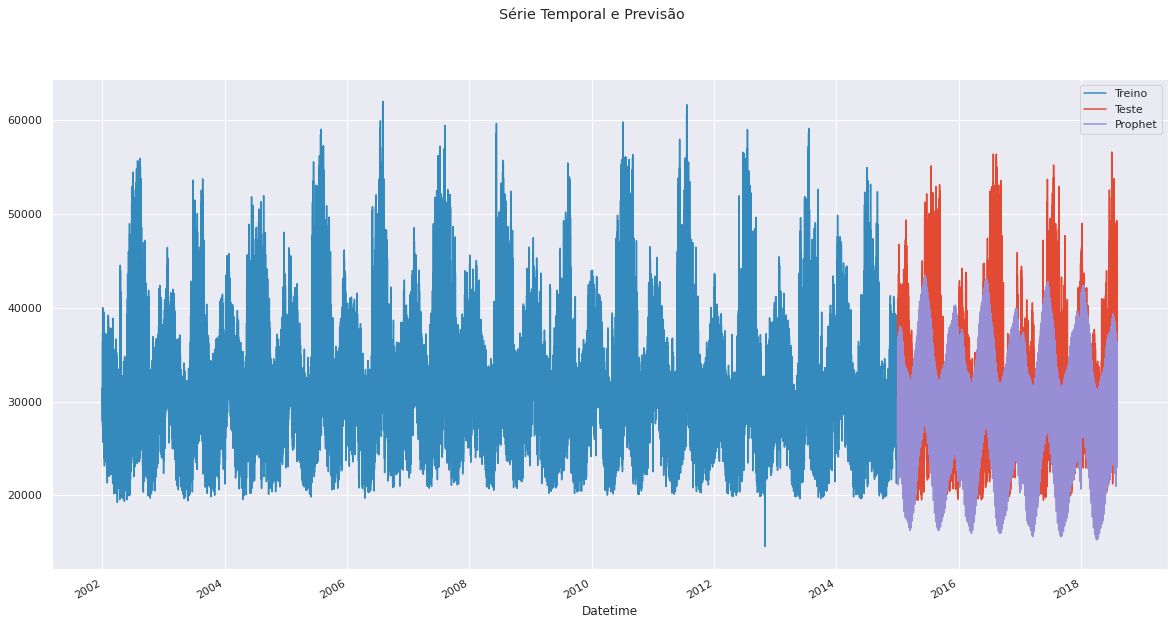

In [46]:
# Plotando o gráfco
treino['PJME_MW'].plot(legend=True, label='Treino', color=color_pal[1]) 
teste['PJME_MW'].plot(legend=True, label='Teste', color=color_pal[0])

previsao_prophet.plot(legend=True, label='Prophet', color=color_pal[2])

plot = plt.suptitle('Série Temporal e Previsão')

# 6.2 Exportando valores preditos

In [49]:
previsao_prophet

Datetime
2015-01-01 00:00:00    30388.714872
2015-12-31 01:00:00    28364.357067
2015-12-31 02:00:00    26860.068811
2015-12-31 03:00:00    25988.419897
2015-12-31 04:00:00    25846.837916
                           ...     
2018-01-01 20:00:00    41261.015237
2018-01-01 21:00:00    40488.176727
2018-01-01 22:00:00    38858.839033
2018-01-01 23:00:00    36650.962942
2018-01-02 00:00:00    34325.332954
Length: 31440, dtype: float64

In [47]:
# Bibliotecas
import csv
from google.colab import files

In [50]:
# Copiando as colunas de interesse
teste['Prophet'] = previsao_prophet
teste_prophet = teste['Prophet'].copy()

# Transformando de Series para DataFrame
teste_prophet = pd.DataFrame(teste_prophet)

# Transformando para csv
teste_prophet.to_csv('teste_prophet.csv')

In [51]:
# A célula anterior deixa o csv na máquina virtual
# Para guardar na computador
files.download("teste_prophet.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>